In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import pandas as pd
from zipfile import ZipFile
from xml.etree import ElementTree as ET

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="MrTJBS44S55knDjD0uOJ")
project = rf.workspace("cassava-disease-classification").project("meteran-air-analog")
version = project.version(3)
dataset = version.download("yolov8")
                

In [5]:
def parse_yolo_labels(label_path):
    with open(label_path, 'r') as file:
        lines = file.readlines()

    boxes = []
    labels = []

    for line in lines:
        values = line.strip().split(' ')
        num_values = len(values)

        # Assuming the first value is the class label, and the next four values are x, y, width, height
        if num_values == 5:
            label = int(values[0])
            x, y, width, height = map(float, values[1:])
            x_min, y_min, x_max, y_max = x - width / 2, y - height / 2, x + width / 2, y + height / 2

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label)
        else:
            print(f"Error: Invalid format in YOLO label file {label_path}")

    return boxes, labels


def check_label_consistency_yolo(label_dir, img_dir):
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

    for label_file in label_files:
        label_path = os.path.join(label_dir, label_file)
        image_path = os.path.join(img_dir, label_file.replace('.txt', '.jpg'))

        if not os.path.exists(image_path):
            print(f"Error: Image not found for YOLO label file {label_file}")
            continue

        boxes, labels = parse_yolo_labels(label_path)
        num_boxes = len(boxes)
        num_labels = len(labels)

        if num_boxes != num_labels:
            print(f"Error: Inconsistent number of bounding boxes and labels in YOLO label file {label_file}")
        else:
            print(f"YOLO label file {label_file} is consistent with {num_boxes} bounding boxes and labels.")

# Example usage
label_directory_yolo = 'METERAN-AIR-ANALOG-7/train/labels'
image_directory_yolo = 'METERAN-AIR-ANALOG-7/train/images'

check_label_consistency_yolo(label_directory_yolo, image_directory_yolo)

YOLO label file 03a01bca-d4c1-4ed8-b462-e2a7f68f067c_jpg.rf.679f00622d5d6afa534c47184d62e5df.txt is consistent with 6 bounding boxes and labels.
YOLO label file 03a01bca-d4c1-4ed8-b462-e2a7f68f067c_jpg.rf.f0ddc73213451f420dba7cd8294b9d34.txt is consistent with 6 bounding boxes and labels.
YOLO label file 03a01bca-d4c1-4ed8-b462-e2a7f68f067c_jpg.rf.fd274ea5d84dc84293989d32816bd729.txt is consistent with 6 bounding boxes and labels.
YOLO label file 03b0a4fa-5de8-4d3a-afaa-9c282270484b_jpg.rf.1b4710c8fb13a1bbf9ae320765c114f0.txt is consistent with 6 bounding boxes and labels.
YOLO label file 03b0a4fa-5de8-4d3a-afaa-9c282270484b_jpg.rf.287c3c6c517ea8816f9d79594b9a6ba2.txt is consistent with 6 bounding boxes and labels.
YOLO label file 03b0a4fa-5de8-4d3a-afaa-9c282270484b_jpg.rf.3551b15027ad38c505d0a39ffea9a52e.txt is consistent with 6 bounding boxes and labels.
YOLO label file 0a1a54a5-1d5e-482e-89b5-76704bc965a6_jpg.rf.0f0c89f2fc28d575eb6879b2fb48df7b.txt is consistent with 6 bounding box

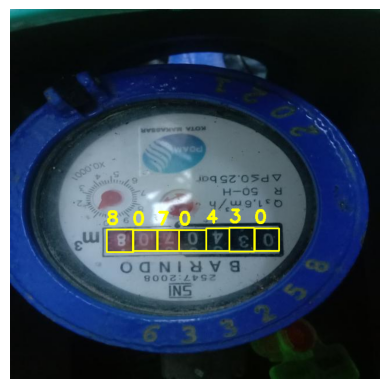

In [9]:
import cv2
import matplotlib.pyplot as plt

def visualize_bbox_yolo(image_path, boxes, labels):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image width and height
    img_height, img_width, _ = image.shape

    # Draw bounding boxes and labels
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box

        # Convert YOLO coordinates to absolute coordinates
        abs_x_min = int(x_min * img_width)
        abs_y_min = int(y_min * img_height)
        abs_x_max = int(x_max * img_width)
        abs_y_max = int(y_max * img_height)

        # Draw rectangle and label
        cv2.rectangle(image_rgb, (abs_x_min, abs_y_min), (abs_x_max, abs_y_max), color=(255, 255, 0), thickness=2)
        cv2.putText(image_rgb, str(label), (abs_x_min, abs_y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Example usage
label_path_yolo = 'METERAN-AIR-ANALOG-7/train/labels/IMG_20241107_054116_jpg.rf.208edc418eeb518d9863f0fdbe37baf9.txt'
image_path_yolo = 'METERAN-AIR-ANALOG-7/train/images/IMG_20241107_054116_jpg.rf.208edc418eeb518d9863f0fdbe37baf9.jpg'

boxes_yolo, labels_yolo = parse_yolo_labels(label_path_yolo)
visualize_bbox_yolo(image_path_yolo, boxes_yolo, labels_yolo)

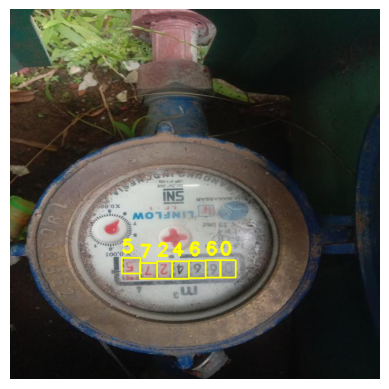

In [11]:
import cv2
import matplotlib.pyplot as plt

def visualize_bbox_yolo(image_path, boxes, labels):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image width and height
    img_height, img_width, _ = image.shape

    # Draw bounding boxes and labels
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box

        # Convert YOLO coordinates to absolute coordinates
        abs_x_min = int(x_min * img_width)
        abs_y_min = int(y_min * img_height)
        abs_x_max = int(x_max * img_width)
        abs_y_max = int(y_max * img_height)

        # Draw rectangle and label
        cv2.rectangle(image_rgb, (abs_x_min, abs_y_min), (abs_x_max, abs_y_max), color=(255, 255, 0), thickness=2)
        cv2.putText(image_rgb, str(label), (abs_x_min, abs_y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Example usage
label_path_yolo = 'METERAN-AIR-ANALOG-7/train/labels/IMG_20241107_062514_jpg.rf.14b00ee93c42355c83c9c0802b0d791a.txt'
image_path_yolo = 'METERAN-AIR-ANALOG-7/train/images/IMG_20241107_062514_jpg.rf.14b00ee93c42355c83c9c0802b0d791a.jpg'

boxes_yolo, labels_yolo = parse_yolo_labels(label_path_yolo)
visualize_bbox_yolo(image_path_yolo, boxes_yolo, labels_yolo)

In [13]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

class YOLODataGenerator(Sequence):
    def __init__(self, label_dir, image_dir, batch_size=32, image_size=(416, 416), num_classes=20):
        self.label_dir = label_dir
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

    def __len__(self):
        return int(np.ceil(len(self.label_files) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size

        if end_index > len(self.label_files):
            end_index = len(self.label_files)

        batch_labels = self.label_files[start_index:end_index]

        X = []
        Y = []

        for label_file in batch_labels:
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(self.image_dir, image_file)
            label_path = os.path.join(self.label_dir, label_file)

            image = cv2.imread(image_path)
            image = cv2.resize(image, self.image_size)
            image = image / 255.0  # Normalize pixel values to be between 0 and 1

            boxes, labels = self.parse_yolo_labels(label_path)

            # Create one-hot encoded labels for multilabel classification
            y_true = np.zeros((self.num_classes,))
            y_true[labels] = 1

            X.append(image)
            Y.append(y_true)

        return np.array(X), np.array(Y)

    def parse_yolo_labels(self, label_path):
        with open(label_path, 'r') as file:
            lines = file.readlines()

        boxes = []
        labels = []

        for line in lines:
            values = line.strip().split(' ')
            num_values = len(values)

            if num_values >= 5:
                labels.extend(map(int, values[:-4]))
            else:
                print(f"Error: Invalid format in YOLO label file {label_path}")

        return boxes, labels

# Example usage
label_directory_yolo = 'METERAN-AIR-ANALOG-7/train/labels'
image_directory_yolo = 'METERAN-AIR-ANALOG-7/train/images'

data_generator = YOLODataGenerator(label_directory_yolo, image_directory_yolo, batch_size=32, image_size=(255, 255), num_classes=10)

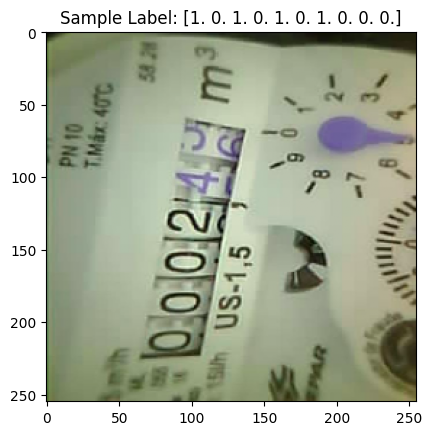

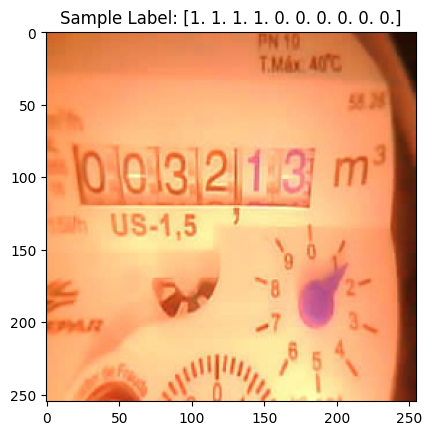

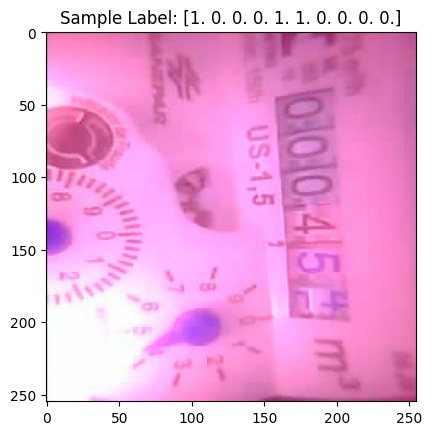

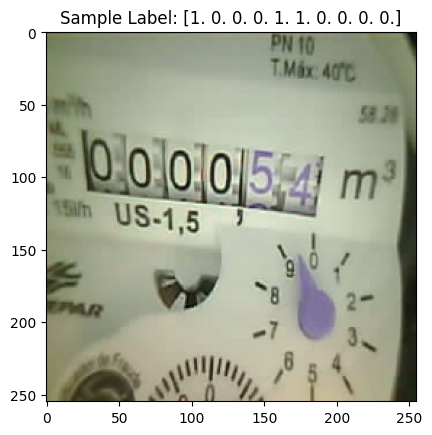

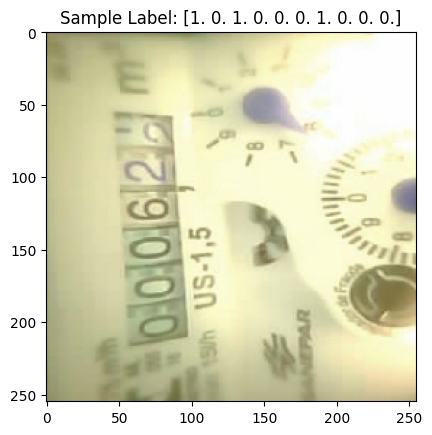

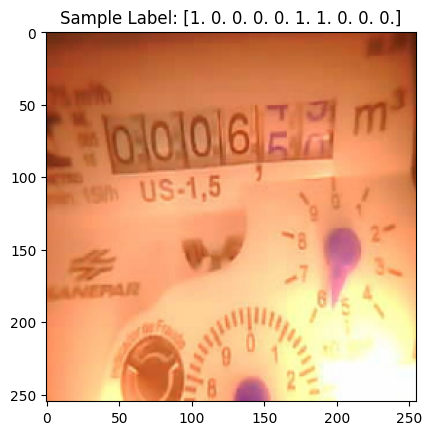

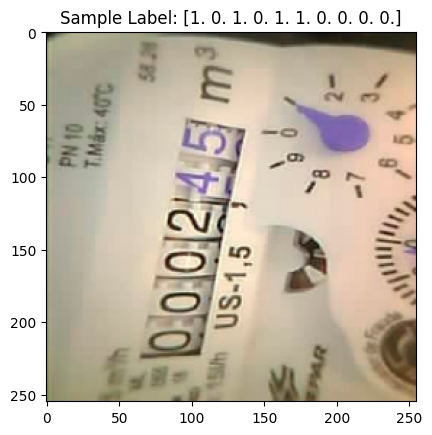

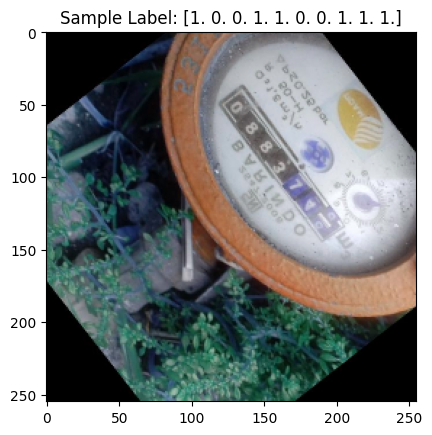

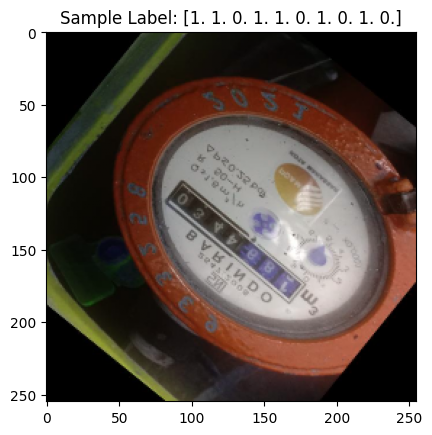

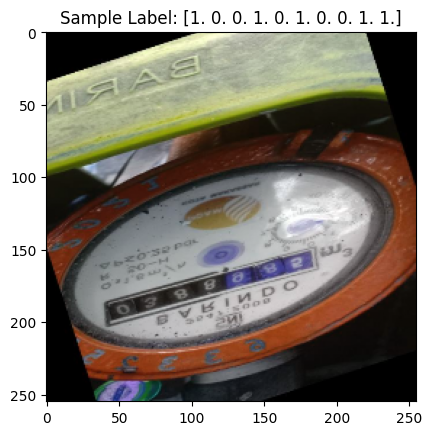

In [14]:
import matplotlib.pyplot as plt

# Ambil beberapa contoh dari generator data
num_samples_to_display = 10

for i in range(num_samples_to_display):
    batch_X, batch_Y = data_generator[i]

    # Pilih satu gambar dan label dari batch
    sample_index = 2  # Ubah indeks ini sesuai keinginan Anda
    sample_image = batch_X[sample_index]
    sample_label = batch_Y[sample_index]

    # Tampilkan gambar dan label
    plt.imshow(sample_image)
    plt.title(f"Sample Label: {sample_label}")
    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50

def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='sigmoid'))  # Sigmoid activation for multilabel classification

    return model

In [ ]:
from ultralytics import YOLO

# Set parameters
batch_size = 50
image_size = 640  # Image size to use for training (can be adjusted, e.g., 640 or 1280)
num_classes = 10  # Number of classes in your dataset
num_epochs = 50  # Number of training epochs

# Define the path to the dataset YAML file
dataset_yaml = 'C:\Skripsi\projek\model\dataset.yaml'

# Initialize the model (YOLOv8)
model = YOLO('yolov8n.pt')  # You can use a pre-trained model like yolov8n.pt or yolov8s.pt

# Train the model
history = model.train(data=dataset_yaml, batch=batch_size, imgsz=image_size, epochs=num_epochs)

# Print training results
print("Training complete!")
print("Final training metrics:")
# Setelah pelatihan selesai, akses metrik Precision dan Recall
precision = history.results_dict['metrics/precision(B)']  # Precision
recall = history.results_dict['metrics/recall(B)']  # Recall

# Mencetak Precision dan Recall terakhir
print(f"Precision Akhir: {precision * 100:.2f}%")
print(f"Recall Akhir: {recall * 100:.2f}%")

print(history)


Ultralytics 8.3.57  Python-3.8.10 torch-2.4.1+cpu CPU (Intel Core(TM) i7-6700HQ 2.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Skripsi\projek\model\dataset.yaml, epochs=20, time=None, patience=100, batch=50, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

train: Scanning C:\Skripsi\projek\model\METERAN-AIR-ANALOG-7\train\labels.cache... 404 images, 0 backgrounds, 0 corrupt: 100%|██████████| 404/404 [00:00<?, ?it/s]
val: Scanning C:\Skripsi\projek\model\METERAN-AIR-ANALOG-7\train\labels.cache... 404 images, 0 backgrounds, 0 corrupt: 100%|██████████| 404/404 [00:00<?, ?it/s]

Plotting labels to runs\detect\train6\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000390625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      2.162      4.771      1.597         45        640: 100%|██████████| 9/9 [03:32<00:00, 23.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:23<00:00, 16.73s/it]

                   all        404       2628   0.000491    0.00968   0.000294   6.83e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.874      4.235       1.32         27        640: 100%|██████████| 9/9 [03:25<00:00, 22.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:17<00:00, 15.59s/it]

                   all        404       2628    0.00867      0.173     0.0158     0.0068



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.636      3.318      1.136         42        640: 100%|██████████| 9/9 [03:22<00:00, 22.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:18<00:00, 15.71s/it]

                   all        404       2628     0.0146      0.378     0.0988     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.556      2.683      1.103         24        640: 100%|██████████| 9/9 [03:01<00:00, 20.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:24<00:00, 16.93s/it]

                   all        404       2628     0.0125      0.378     0.0917     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.518       2.32      1.089         22        640: 100%|██████████| 9/9 [03:15<00:00, 21.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:16<00:00, 15.39s/it]

                   all        404       2628     0.0142      0.458     0.0716     0.0391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.428      2.017      1.073         23        640: 100%|██████████| 9/9 [03:03<00:00, 20.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:20<00:00, 16.05s/it]

                   all        404       2628     0.0207       0.75      0.203      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.444      1.896      1.085         40        640: 100%|██████████| 9/9 [03:09<00:00, 21.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:19<00:00, 15.86s/it]

                   all        404       2628     0.0217      0.781      0.221      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.443      1.835      1.097         31        640: 100%|██████████| 9/9 [03:03<00:00, 20.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:15<00:00, 15.13s/it]

                   all        404       2628      0.025      0.724      0.256      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.423      1.766      1.078         41        640: 100%|██████████| 9/9 [03:06<00:00, 20.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:17<00:00, 15.56s/it]

                   all        404       2628      0.186      0.514      0.316      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.426      1.713      1.076         43        640: 100%|██████████| 9/9 [03:10<00:00, 21.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:11<00:00, 14.32s/it]

                   all        404       2628      0.915     0.0833      0.347      0.206


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G       1.39      1.647      1.124         25        640: 100%|██████████| 9/9 [02:51<00:00, 19.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:10<00:00, 14.13s/it]

                   all        404       2628      0.921      0.155      0.402      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.367      1.536      1.091         25        640: 100%|██████████| 9/9 [02:46<00:00, 18.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.94s/it]

                   all        404       2628      0.711      0.335      0.464      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.328      1.492      1.074         26        640: 100%|██████████| 9/9 [02:47<00:00, 18.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:11<00:00, 14.27s/it]

                   all        404       2628      0.667      0.399      0.534      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.384      1.441      1.105         26        640: 100%|██████████| 9/9 [02:46<00:00, 18.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:10<00:00, 14.07s/it]

                   all        404       2628      0.634      0.443      0.554      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.286      1.359      1.058         25        640: 100%|██████████| 9/9 [02:47<00:00, 18.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.98s/it]

                   all        404       2628      0.655      0.455      0.581      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.327      1.343      1.077         27        640: 100%|██████████| 9/9 [02:46<00:00, 18.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.75s/it]

                   all        404       2628      0.629      0.499      0.609      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.319      1.297      1.076         27        640: 100%|██████████| 9/9 [02:47<00:00, 18.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.66s/it]

                   all        404       2628      0.622      0.527      0.626      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.303      1.342       1.06         27        640: 100%|██████████| 9/9 [02:50<00:00, 18.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:07<00:00, 13.57s/it]

                   all        404       2628      0.646      0.588       0.67      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.323      1.247      1.078         26        640: 100%|██████████| 9/9 [02:49<00:00, 18.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:07<00:00, 13.45s/it]

                   all        404       2628      0.665      0.594      0.685      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.251      1.207      1.066         25        640: 100%|██████████| 9/9 [02:46<00:00, 18.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.30s/it]

                   all        404       2628      0.676       0.61      0.702      0.456



20 epochs completed in 1.422 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 6.3MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.57  Python-3.8.10 torch-2.4.1+cpu CPU (Intel Core(TM) i7-6700HQ 2.60GHz)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:56<00:00, 11.21s/it]


                   all        404       2628      0.678      0.609      0.702      0.456
                     0        404        957      0.944      0.962      0.984       0.69
                     1        153        198       0.75      0.683      0.786      0.502
                     2        188        230      0.912      0.496      0.751        0.5
                     3        168        213      0.509      0.577      0.645      0.426
                     4        173        203      0.632      0.729      0.765      0.499
                     5        132        138      0.683       0.58      0.676      0.457
                     6        150        195       0.73      0.533      0.675      0.433
                     7        117        153      0.668       0.68      0.757      0.456
                     8        126        171      0.469      0.363      0.434      0.259
                     9        140        170      0.484      0.485      0.546      0.336
Speed: 2.2ms preproce

KeyError: 'precision'

In [47]:
from ultralytics import YOLO

# Set parameters
batch_size = 50
image_size = 640  # Image size to use for training (can be adjusted, e.g., 640 or 1280)
num_classes = 10  # Number of classes in your dataset
num_epochs = 50  # Number of training epochs

# Define the path to the dataset YAML file
dataset_yaml = 'C:\Skripsi\projek\model\dataset.yaml'

# Initialize the model (YOLOv8)
model = YOLO('yolov8n.pt')  # You can use a pre-trained model like yolov8n.pt or yolov8s.pt

# Train the model
history = model.train(data=dataset_yaml, batch=batch_size, imgsz=image_size, epochs=num_epochs)

# Print training results
print("Training complete!")
print("Final training metrics:")
# Setelah pelatihan selesai, akses metrik Precision dan Recall
precision = history.results_dict['metrics/precision(B)']  # Precision
recall = history.results_dict['metrics/recall(B)']  # Recall

# Mencetak Precision dan Recall terakhir
print(f"Precision Akhir: {precision * 100:.2f}%")
print(f"Recall Akhir: {recall * 100:.2f}%")

print(history)


Ultralytics 8.3.57  Python-3.8.10 torch-2.4.1+cpu CPU (Intel Core(TM) i7-6700HQ 2.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Skripsi\projek\model\dataset.yaml, epochs=50, time=None, patience=100, batch=50, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

train: Scanning C:\Skripsi\projek\model\METERAN-AIR-ANALOG-7\train\labels.cache... 404 images, 0 backgrounds, 0 corrupt: 100%|██████████| 404/404 [00:00<?, ?it/s]
val: Scanning C:\Skripsi\projek\model\METERAN-AIR-ANALOG-7\train\labels.cache... 404 images, 0 backgrounds, 0 corrupt: 100%|██████████| 404/404 [00:00<?, ?it/s]


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000390625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.162      4.771      1.597         45        640: 100%|██████████| 9/9 [02:58<00:00, 19.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:17<00:00, 15.48s/it]

                   all        404       2628   0.000491    0.00968   0.000294   6.83e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.872      4.222      1.317         27        640: 100%|██████████| 9/9 [02:57<00:00, 19.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:27<00:00, 17.54s/it]

                   all        404       2628    0.00957      0.198     0.0193    0.00835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.634      3.306      1.137         42        640: 100%|██████████| 9/9 [03:06<00:00, 20.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:19<00:00, 15.93s/it]


                   all        404       2628     0.0141      0.359     0.0988     0.0603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.552      2.634      1.106         24        640: 100%|██████████| 9/9 [02:57<00:00, 19.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:17<00:00, 15.59s/it]

                   all        404       2628     0.0121      0.288     0.0902      0.053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.512      2.282      1.094         22        640: 100%|██████████| 9/9 [02:56<00:00, 19.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:16<00:00, 15.35s/it]

                   all        404       2628     0.0129      0.335      0.056     0.0304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.423      1.991      1.075         23        640: 100%|██████████| 9/9 [03:04<00:00, 20.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:18<00:00, 15.74s/it]

                   all        404       2628     0.0181      0.741      0.217      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.447      1.891      1.091         40        640: 100%|██████████| 9/9 [03:05<00:00, 20.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:17<00:00, 15.43s/it]

                   all        404       2628     0.0181      0.737      0.236      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.466      1.827      1.106         31        640: 100%|██████████| 9/9 [03:00<00:00, 20.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:16<00:00, 15.21s/it]

                   all        404       2628     0.0184      0.722      0.239      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.439      1.765       1.09         41        640: 100%|██████████| 9/9 [02:57<00:00, 19.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:14<00:00, 14.91s/it]

                   all        404       2628      0.294      0.364      0.318      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G       1.43      1.706      1.085         43        640: 100%|██████████| 9/9 [02:52<00:00, 19.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:11<00:00, 14.22s/it]

                   all        404       2628      0.912     0.0565       0.32      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.419      1.633      1.103         23        640: 100%|██████████| 9/9 [02:51<00:00, 19.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:10<00:00, 14.06s/it]

                   all        404       2628      0.691      0.143       0.36      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.421      1.582      1.103         25        640: 100%|██████████| 9/9 [02:51<00:00, 19.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.70s/it]

                   all        404       2628      0.739      0.299      0.481      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.397      1.462      1.077         44        640: 100%|██████████| 9/9 [02:52<00:00, 19.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.32s/it]

                   all        404       2628      0.774      0.291      0.506      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.346        1.4      1.081         17        640: 100%|██████████| 9/9 [02:51<00:00, 19.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.20s/it]

                   all        404       2628       0.64      0.402      0.513      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.341      1.355      1.068         46        640: 100%|██████████| 9/9 [02:51<00:00, 19.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:07<00:00, 13.41s/it]

                   all        404       2628       0.63      0.424       0.52      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.334      1.327       1.07         32        640: 100%|██████████| 9/9 [02:51<00:00, 19.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.34s/it]

                   all        404       2628       0.56      0.452      0.534      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.303      1.269      1.045         33        640: 100%|██████████| 9/9 [02:52<00:00, 19.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.29s/it]

                   all        404       2628      0.631      0.529      0.606      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.332      1.301      1.079         18        640: 100%|██████████| 9/9 [02:52<00:00, 19.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.35s/it]

                   all        404       2628      0.624      0.576      0.643      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G       1.37      1.307      1.089         31        640: 100%|██████████| 9/9 [02:52<00:00, 19.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.23s/it]

                   all        404       2628      0.577      0.574      0.621      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.362      1.287      1.069         33        640: 100%|██████████| 9/9 [02:52<00:00, 19.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.22s/it]

                   all        404       2628      0.676      0.591      0.682      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.311      1.199      1.049         47        640: 100%|██████████| 9/9 [02:51<00:00, 19.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.21s/it]

                   all        404       2628      0.642       0.61      0.681      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.306       1.23      1.056         47        640: 100%|██████████| 9/9 [02:53<00:00, 19.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.35s/it]

                   all        404       2628      0.688       0.64       0.74       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.276      1.167      1.039         32        640: 100%|██████████| 9/9 [02:51<00:00, 19.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.10s/it]

                   all        404       2628      0.683       0.64      0.717      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.289      1.177      1.051         57        640: 100%|██████████| 9/9 [02:51<00:00, 19.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:07<00:00, 13.42s/it]

                   all        404       2628      0.705      0.627      0.718      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G       1.31      1.166      1.059         45        640: 100%|██████████| 9/9 [02:52<00:00, 19.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.30s/it]

                   all        404       2628      0.693      0.647      0.731      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.313       1.16      1.058         52        640: 100%|██████████| 9/9 [02:52<00:00, 19.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.06s/it]

                   all        404       2628      0.743      0.661      0.778      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.347      1.142      1.212         13        640: 100%|██████████| 9/9 [02:52<00:00, 19.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.32s/it]

                   all        404       2628      0.726      0.674      0.767      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.252      1.023      1.046         41        640: 100%|██████████| 9/9 [02:52<00:00, 19.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.25s/it]

                   all        404       2628      0.742      0.681      0.788      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.197      0.974      1.038         42        640: 100%|██████████| 9/9 [02:51<00:00, 19.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.28s/it]

                   all        404       2628      0.717      0.657      0.756      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.211     0.9937       1.01         38        640: 100%|██████████| 9/9 [02:51<00:00, 19.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.06s/it]

                   all        404       2628      0.753      0.696      0.794      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.219     0.9983      1.024         31        640: 100%|██████████| 9/9 [02:51<00:00, 19.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.06s/it]

                   all        404       2628      0.749      0.727      0.819      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.211      1.008      1.035         32        640: 100%|██████████| 9/9 [02:53<00:00, 19.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.20s/it]

                   all        404       2628      0.718      0.733      0.811      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.222     0.9841      1.035         38        640: 100%|██████████| 9/9 [03:08<00:00, 21.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.93s/it]

                   all        404       2628      0.788      0.738      0.846       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G       1.19     0.9515      1.015         30        640: 100%|██████████| 9/9 [02:54<00:00, 19.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.23s/it]

                   all        404       2628      0.793      0.737      0.855      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.245     0.9953       1.03         43        640: 100%|██████████| 9/9 [02:54<00:00, 19.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.33s/it]

                   all        404       2628      0.825      0.756      0.867      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.197     0.9368      1.014         32        640: 100%|██████████| 9/9 [02:52<00:00, 19.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.14s/it]

                   all        404       2628      0.781      0.758      0.854      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.201      0.996      1.016         51        640: 100%|██████████| 9/9 [02:51<00:00, 19.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.97s/it]

                   all        404       2628       0.81      0.788      0.882       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.211     0.9246      1.028         43        640: 100%|██████████| 9/9 [02:50<00:00, 18.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.02s/it]

                   all        404       2628      0.847      0.759      0.887      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.208     0.9052       1.05         22        640: 100%|██████████| 9/9 [02:52<00:00, 19.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.16s/it]

                   all        404       2628      0.851      0.788      0.897      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.207     0.9654      1.027         18        640: 100%|██████████| 9/9 [02:48<00:00, 18.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.09s/it]

                   all        404       2628      0.855       0.78      0.902      0.593


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.148     0.8454      1.023         26        640: 100%|██████████| 9/9 [02:45<00:00, 18.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.13s/it]

                   all        404       2628      0.831      0.798      0.898      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.135      0.796      1.022         26        640: 100%|██████████| 9/9 [02:46<00:00, 18.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.20s/it]

                   all        404       2628      0.845      0.799      0.905      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.131     0.8002      1.027         24        640: 100%|██████████| 9/9 [02:46<00:00, 18.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.24s/it]

                   all        404       2628      0.891      0.797      0.913      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.124     0.7996      1.013         26        640: 100%|██████████| 9/9 [02:46<00:00, 18.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.99s/it]

                   all        404       2628      0.883      0.795      0.911      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G       1.14     0.7965       1.01         26        640: 100%|██████████| 9/9 [02:44<00:00, 18.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.99s/it]

                   all        404       2628      0.888      0.833      0.928      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.111     0.7739      1.002         26        640: 100%|██████████| 9/9 [02:45<00:00, 18.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.06s/it]

                   all        404       2628      0.894      0.838       0.93      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.128     0.7963      1.005         27        640: 100%|██████████| 9/9 [02:48<00:00, 18.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.12s/it]

                   all        404       2628      0.893      0.846      0.934       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G        1.1     0.7525      1.005         26        640: 100%|██████████| 9/9 [02:45<00:00, 18.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.11s/it]

                   all        404       2628      0.884      0.839      0.934      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.113      0.782      1.016         26        640: 100%|██████████| 9/9 [02:46<00:00, 18.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.03s/it]

                   all        404       2628      0.886      0.854      0.938      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.099     0.7439      1.017         26        640: 100%|██████████| 9/9 [02:44<00:00, 18.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.05s/it]

                   all        404       2628      0.889      0.858      0.939      0.649



50 epochs completed in 3.362 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 6.3MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics 8.3.57  Python-3.8.10 torch-2.4.1+cpu CPU (Intel Core(TM) i7-6700HQ 2.60GHz)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:55<00:00, 11.05s/it]


                   all        404       2628      0.886      0.861      0.939      0.649
                     0        404        957      0.996      0.985      0.994      0.729
                     1        153        198      0.945      0.864      0.958      0.652
                     2        188        230      0.917      0.859      0.958      0.656
                     3        168        213      0.852      0.784      0.896      0.612
                     4        173        203      0.926       0.86      0.951       0.66
                     5        132        138      0.827      0.812      0.932      0.666
                     6        150        195      0.891      0.835      0.939      0.671
                     7        117        153      0.882      0.935      0.959      0.611
                     8        126        171      0.752      0.883      0.896      0.601
                     9        140        170       0.87      0.788      0.907      0.631
Speed: 2.4ms preproce

In [ ]:
# Setelah pelatihan selesai, akses metrik Precision dan Recall
precision = history.results_dict['precision']  # Precision
recall = history.results_dict['recall']  # Recall

# Mencetak Precision dan Recall terakhir
print(f"Precision Terakhir: {precision[-1]:.4f}")
print(f"Recall Terakhir: {recall[-1]:.4f}")


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000244EFDB8820>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

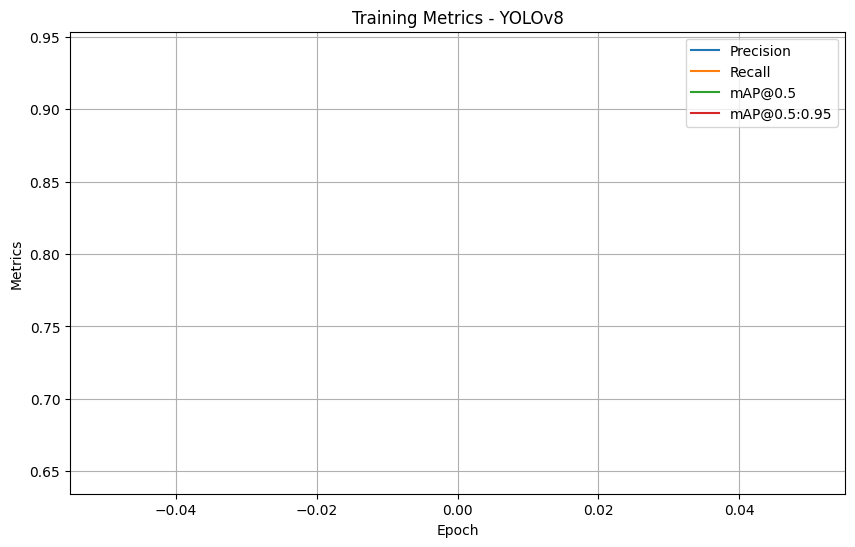

In [50]:
from ultralytics import YOLO
import matplotlib.pyplot as plt


# Access metrics from the training process
results = history.results_dict

# Extract the metrics
precision = results.get('metrics/precision(B)', [])
recall = results.get('metrics/recall(B)', [])
mAP50 = results.get('metrics/mAP50(B)', [])
mAP50_95 = results.get('metrics/mAP50-95(B)', [])

# Plot the metrics
plt.figure(figsize=(10, 6))
if precision:
    plt.plot(precision, label="Precision")
if recall:
    plt.plot(recall, label="Recall")
if mAP50:
    plt.plot(mAP50, label="mAP@0.5")
if mAP50_95:
    plt.plot(mAP50_95, label="mAP@0.5:0.95")

plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.title("Training Metrics - YOLOv8")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
from PIL import Image
import os
from ultralytics import YOLO
from sklearn.metrics import precision_recall_fscore_support

# Muat model YOLOv8
model = YOLO(r'C:\Skripsi\projek\model\yolov8n.pt')  # Path ke model YOLOv8 yang sudah dilatih

# Dataset dan DataLoader
image_dir = r'C:\Skripsi\projek\model\METERAN-AIR-ANALOG-7\test\images'
label_dir = r'C:\Skripsi\projek\model\METERAN-AIR-ANALOG-7\test\labels'

# Menentukan prediksi dengan YOLOv8
all_preds = []
all_labels = []

for img_name in os.listdir(image_dir):
    if img_name.endswith(('.jpg', '.png')):
        img_path = os.path.join(image_dir, img_name)

        # Buka gambar dengan PIL
        img = Image.open(img_path)

        # Prediksi menggunakan model YOLOv8
        results = model(img)  # Pass the PIL Image directly to the model

        # Menyimpan hasil prediksi (kelas) dari hasil YOLOv8
        if len(results[0].boxes.data) > 0:
            preds = [int(result['class']) for result in results[0].boxes.data.tolist()]
        else:
            preds = []  # No predictions made
        all_preds.extend(preds)

        # Baca label yang benar dari file (ground truth)
        label_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_name)
        with open(label_path, 'r') as f:
            label = int(f.readline().split()[0])  # Ambil kelas pertama sebagai label
        all_labels.append(label)

# Evaluasi menggunakan precision, recall, f1-score
precision, recall, fscore, support = precision_recall_fscore_support(
    all_labels, all_preds, average='micro'
)

# Tampilkan hasil evaluasi
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {fscore}")
print(f"Support: {support}")



0: 640x640 (no detections), 49.8ms
Speed: 10.8ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



NotImplementedError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
Meta: registered at /dev/null:154 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:53 [backend fallback]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:57 [backend fallback]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:65 [backend fallback]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:69 [backend fallback]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:77 [backend fallback]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:61 [backend fallback]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:90 [backend fallback]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:73 [backend fallback]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:81 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:297 [backend fallback]
AutocastCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:34 [kernel]
AutocastXPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:351 [backend fallback]
AutocastCUDA: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:27 [kernel]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:157 [backend fallback]


In [ ]:
end_time_training = time.time()

In [ ]:
# Record end time after evaluation
end_time_evaluation = time.time()
evaluation_time = end_time_evaluation - start_time
print(f"Evaluation Time: {evaluation_time:.2f} seconds")

# Total execution time
total_time = evaluation_time + (end_time_training - start_time)
print(f"Total Execution Time: {total_time:.2f} seconds")